# Course Project: Fake News Detection
## Deep Neural Network Realization
#### Group 2, Tinglin Duan, Tianyi Xie, Junxi Xu, Zhennan Ying, Qianyue Zhang

### 1. Introduction


#### 1.1 Project Introduction
This project is based on the Phase 1 of the $1 million Leaders Prize 2019: Fact or Fake News Challenge. This Challenge aims to stop misinformation and fake news spreading with Machine Learning based fact-checking. In Phase 1, each team is expected to design fact-checking algorithms to label claims as True, Partly True or False.

Input: metadata file with claim information, training data is given with truth labels

Output: predicted truth labels without any human intervention

Note: in order to reproduce the result, one should have all the data files from the Datacup official website and download the stop_words.txt and embedding file from https://drive.google.com/drive/folders/1KbThhafJK5Aoa3zlvF-BbN2_QSDbRYXD?usp=sharing

#### 1.2 Import libraries

In [ ]:
import pickle
import json
import os
from os import listdir
from os.path import isfile, join, exists, split
import collections
import time
import re
import itertools
import random
import csv
from string import punctuation
import subprocess as sp
from statistics import mode
from collections import Counter

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import *
from keras.layers import Multiply, Average, TimeDistributed
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Dropout, MaxPooling1D, Convolution1D
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model, model_from_json

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib

from gensim.models import word2vec
# print(device_lib.list_local_devices())
np.random.seed(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dir_path = os.path.dirname(os.path.realpath('__file__')) + '/'
print(dir_path)
Bookkeeping_path = dir_path + "bookkeeping/"
if not os.path.exists(Bookkeeping_path):
    os.makedirs(Bookkeeping_path)
Model_path = dir_path + "models/"
if not os.path.exists(Model_path):
    os.makedirs(Model_path)

/content/


#### 1.3 Global Static Variable Definition

In [ ]:
############################################### RNN PART ################################################
stop_words_file = dir_path + 'stop_words.txt'
article_folder = dir_path + 'train_articles'
json_folder = dir_path + 'train.json'
glove_data_file = dir_path + 'glove.6B.100d.txt'

save_model_json_1 = Model_path + 'jupyter_trained_1.json'
save_model_weights_1 = Model_path + 'jupyter_trained_1.h5'

save_model_json_2 = Model_path + 'jupyter_trained_2.json'
save_model_weights_2 = Model_path + 'jupyter_trained_2.h5'

save_model_json_3 = Model_path + 'jupyter_trained_3.json'
save_model_weights_3 = Model_path + 'jupyter_trained_3.h5'

save_model_json_4 = Model_path + 'jupyter_trained_4.json'
save_model_weights_4 = Model_path + 'jupyter_trained_4.h5'

MAX_LEN_ART = 1500
MAX_LEN_CLAIM = 100
EMBEDDING_SIZE = 100
unit_size = 256

############################################### CNN PART ################################################
# Model Hyperparameters
embedding_dim = 50
filter_sizes = (3, 8)
num_filters = 10
dropout_prob = (0.5, 0.2)
hidden_dims = 50
output_dims = 3

# Training parameters
batch_size = 64
num_epochs = 5 # early stopping

# Word2Vec parameters (see train_word2vec)
min_word_count = 1
context = 10

############################################### NB PART ################################################
save_NBmodel = Model_path + 'NBmodel.sav'

### 2 Training Data Evaluation

#### 2.1 Data import

In [ ]:
def word_split(paragraph):
    return [splited.lower() for splited in nltk.word_tokenize(paragraph)]

In [ ]:
def bar_plot(x, y, x_label, y_label, title):
    y_pos = np.arange(len(x))
    performance = y

    plt.figure(figsize=(12,12))
    plt.barh(y_pos, y, align='center', alpha=0.5)
    plt.yticks(y_pos, x)
    plt.ylabel(x_label)
    plt.xlabel(y_label)
    plt.title(title)

    plt.show()

In [ ]:
with open(json_folder) as json_file:
    df = (pd.DataFrame(json.load(json_file))).reset_index()
    train, test = train_test_split(df, test_size=0.2)
    train['claim_splitted'] = train.claim.apply(word_split)
    test['claim_splitted'] = test.claim.apply(word_split)

The imported json file is divided into train and test sets. The test set in this case is just a validation set to see model jit level. The train/test proportion is set to be 0.8/0.2

In [ ]:
train.head()

,index,claim,claimant,date,label,related_articles,id,claim_splitted
3729,3729,"Says U.S. Sen. Ron Johnson ""doesn't even belie...",Russ Feingold,2016-10-06,1,"[1088, 26723]",4107,"[says, u.s., sen., ron, johnson, ``, does, n't..."
12790,12790,"“By denying climate change, [Stephen Harper] d...",Justin Trudeau,2015-07-09,0,"[97541, 97901, 98022, 100860]",14091,"[“, by, denying, climate, change, ,, [, stephe..."
3822,3822,"Says President Donald Trump ""has signed more l...",Mike Pence,2017-07-18,1,"[6007, 28240, 28245, 88386, 47172]",4210,"[says, president, donald, trump, ``, has, sign..."
10346,10346,"""Obama's Private 'Security' Company Sets Up M...",Various websites,2018-04-30,0,"[26939, 37849]",11405,"[``, obama, 's, private, 'security, ', company..."
4858,4858,“I was against the war in Iraq. Has not been d...,Donald Trump,2016-10-09,0,"[58855, 57620, 58877, 58858, 76663, 58736, 588...",5347,"[“, i, was, against, the, war, in, iraq, ., ha..."


In [ ]:
test.head()

,index,claim,claimant,date,label,related_articles,id,claim_splitted
11713,11713,"""Collusion is not a crime.""",Donald Trump,2018-07-31,1,"[42998, 18667, 43017, 33290, 48700, 50317, 50335]",12899,"[``, collusion, is, not, a, crime, ., '']"
3407,3407,"""It took us four years to balance the budget. ...",Bill Clinton,2012-06-02,1,"[73809, 93667, 3636]",3745,"[``, it, took, us, four, years, to, balance, t..."
10621,10621,"""Obama keeps talking about getting rid of all ...",Dick Cheney,2015-07-14,1,"[88354, 5530, 62990, 2507, 90824]",11705,"[``, obama, keeps, talking, about, getting, ri..."
5506,5506,President Trump praised KFC founder Colonel Sa...,,2017-05-22,0,"[125263, 125503, 23295]",6064,"[president, trump, praised, kfc, founder, colo..."
4567,4567,"In 2008, ""only 54 percent of Latinos in Texas ...",Battleground Texas,2013-02-26,1,"[15506, 16343, 15367]",5024,"[in, 2008, ,, ``, only, 54, percent, of, latin..."


Here is the json dictionary training data format:

Main attributes: claim; claimant; date; label (0: false, 1: partly true, 2: true); related articles; id

Example: {'claim': "A line from George Orwell's novel 1984 predicts the power of smartphones.", 'claimant': '', 'date': '2017-07-17', 'label': 0, 'related_articles': [122094, 122580, 130685, 134765], 'id': 0}

In this project, it is desired to use the supported data to classify the label.

In [ ]:
claim_counter = {}

for claim in df['claim']:
    if len(claim) not in claim_counter:
        claim_counter[len(claim)] = 1
    else:
        claim_counter[len(claim)] += 1

print(Counter(claim_counter).most_common(10))

[(86, 185), (88, 185), (76, 175), (87, 169), (92, 161), (78, 158), (85, 157), (73, 155), (77, 154), (101, 153)]


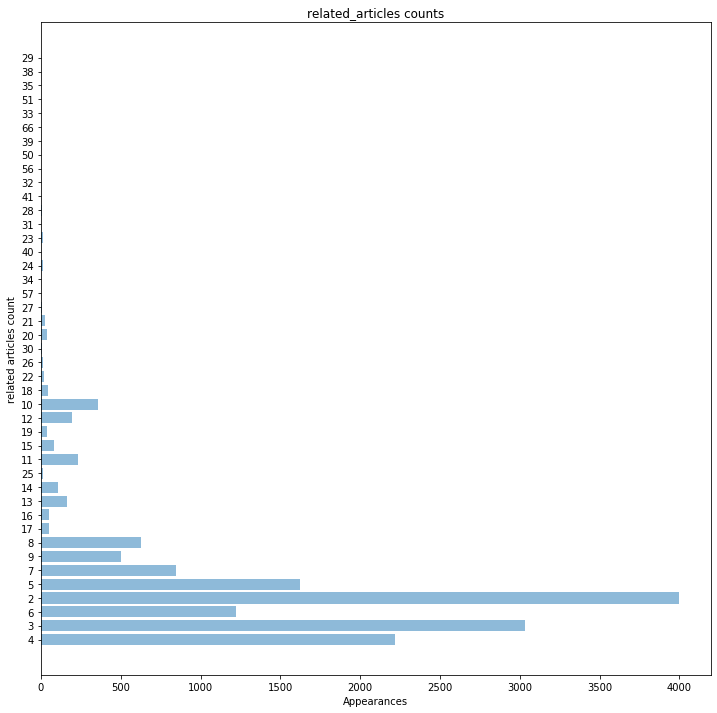

In [ ]:
related_counter = {}

for articles in df['related_articles']:
    if len(articles) not in related_counter:
        related_counter[len(articles)] = 1
    else:
        related_counter[len(articles)] += 1

bar_plot(list(related_counter.keys()), list(related_counter.values()), 'related articles count', 'Appearances', 'related_articles counts')

#### 2.2 Data NAN filling

In [ ]:
def heat_plot(df):
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df, cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

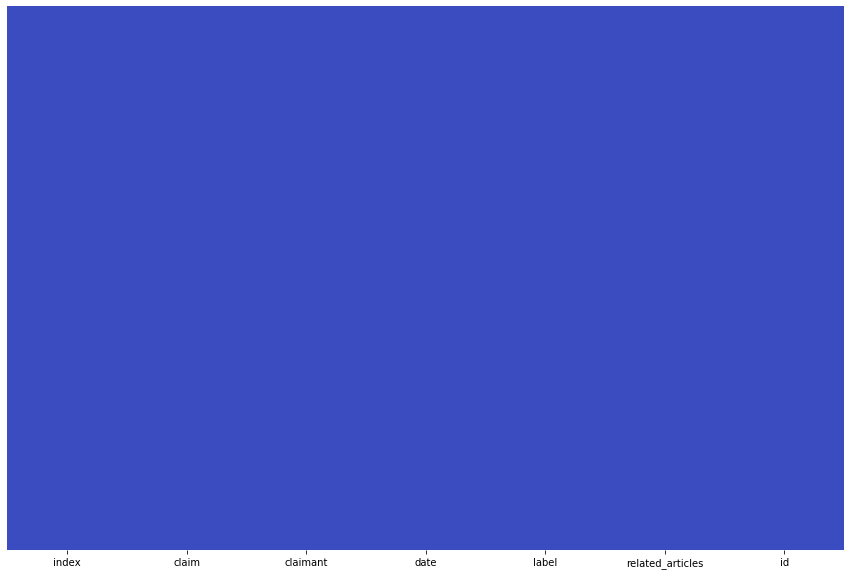

In [ ]:
heat_plot(df.isnull())

This is a very appropriately filled dataset where no NAN entry has been found

#### 2.3 Project Strategy

In this part of the project, deep neural networks such as RNN, LSTM, CNN and Transformer are desired to be implemented. We are interested in the word sequence importance and text information rather than individual text features. Hence we will implement the model based on the columns "claim" and "related_articles" where we could evaluation text information.

##### 2.3.1 LSTM

Long Short Term Memory networks (LSTMs) are a special kinds of Recurrent Neural Networks (RNN), and was proposed by Hochreiter and Schmidhube as early as 1997. Compared with ordinary neural networks, the network is capable of remembering long term memories, which has proven to be essentially useful in speech recognition and sentimental analysis tasks. Compared with other existing RNN networks, it has three gates: input, output and forget. Considering the nature of this project involves text recognition, LSTM is a natural option. In this project's implementation, two LSTM layers with unit size 256 has been used.

##### 2.3.2 Bi-directional LSTM

Bidirectional LSTM is basically a LSTM with both directions, in other words, the states in the neural network has access to both "past" and "future" information. This kind of model with same parameters as the normal LSTM has been implemented as well.

##### 2.3.3 LSTM with attention

During the years of implementation and discussion, gradient explosion and vanishing might happen with very long sentences, since we are multiplying and processing the gradients too many times. In order to resolve this matter, attention modules have been designed. In traditional LSTMs or RNNs, the network has been divided into "encoding" and "decoding" process, where the decoding process will only deal with the last context vector (or "thought" vector) at the end of the encoding process. This would cause the mentioned gradient explosion or vanishing since it would be very likely that the information of previous text would be lost along the way to generate the thought vector. Attention modules are designed such that all the intermediate states would be taken into consideration and have an impact on the decoding process.

##### 2.3.4 LSTM with attention, supplied with extra feature related articles

Apart from pure claim text analysis, it would also be valuable to take the related articles into accont. Checking reference sources is also a reliable way to tell if a news is valid for humans. Hence a deep neural network that takes the related articles text into consideration has been implemented as well. We averages the prediction distribution result with that of the previous claim LSTM and derives the final result.

##### 2.3.5 Naive Bayes

The Naive Bayes classifier is a probabilistic classifier. We basically compute the probability of each claim being in the each class (0: false, 1: partly true, 2: true). Since we are interested in the word sequence importance, we implement a model called Bag of Words to vectorize the claim based on the pre-constructed vocabulary. Then a Naive Bayes classifier is implemented to find the best class for each claim based on the maximum likelihood. However, Naive Bayes is a generative model which models the joint distribution of feature X and target Y to predict the P(y|x). It assumes all features to be conditionally independent, which means these features dont have correlation with each other and each feature is corresponding to one target.

##### 2.3.6 Convolutional Neural Network (CNN)

CNN uses convolution in place of general matrix multiplication. Although CNN is not widely used in natural language processing, it is a powerful when handling complex classification problem. Based on the information provided in Yoon Kim's paper (https://arxiv.org/pdf/1408.5882v2.pdf), our group decided to implement a CNN classifier in order to compare the results woth the RNN classifiers mentioned above. As Kim's paper suggested, we also implemented an embedding layer taking advantage of the Word2vec function.

### 3 Data Pre-processing

In [ ]:
def save_obj(obj, name):
    with open(Bookkeeping_path + name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(Bookkeeping_path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

First we will perform basic preceesing to the splitted claims, excluding the punctuations

In [ ]:
# training part
claim_list = train['claim'].values
claimant_list = train['claimant'].values
date_list = train['date'].values
labels_list = list(train['label'].values)
related_list = train['related_articles'].values
id_list = list(train['id'].values)

# testing part
# we are interested in 'claim', 'related article'
test_claim_list = test['claim'].values
test_related_list = test['related_articles'].values
test_labels_list = list(test['label'].values)

# retrive all articles from the folder
all_articles = [f for f in listdir(article_folder) if isfile(join(article_folder, f))]
all_claims_splitted = []
most_common_dic = {}

for index, row in train.iterrows():
    # preprocessing here, replace useless symbols
    all_claims_splitted.append(' '.join(cp for cp in row['claim_splitted'] if cp not in punctuation))

Initilize a tokenizer and fit on all the claims

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_claims_splitted)

save_obj(tokenizer, "tokenizer")

### 4 Feature Generation

In this part we will generate different kinds of features for the training part. We will do it two ways:

1. [claim] purely claim as feature
2. [claim, related_article text] claim + related article text as two features

In [ ]:
def split_features(features, label):
    features_split = []
    label_list = []
    for i in range(len(features[1])):
        features_split.append([features[0], features[1][i]])
        label_list.append(label)

    return features_split, label_list

In [ ]:
def feature_pre_generation(claim_list, related_list):
    # vector [claim, related articles]
    features = []
    for i in range(claim_list.shape[0]):
        features.append([claim_list[i], related_list[i]])
    return features

In [ ]:
def feature_generation_claim_and_related(feature_list, label_list, X, Y):
    for i in range(len(label_list)):
        feat, lab = feature_list[i], label_list[i]
        try:
            split_feats, corresponding_labs = split_features(feat, lab)
            for j in range(len(split_feats)):
                X.append(split_feats[j])
                Y.append(corresponding_labs[j])
        except:
            pass
    return X, Y

In [ ]:
def fill_sets_one(X, Y, tokenizer, feature_list, label_list):
    labels = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    labels = np.array(labels)
    for i in range(len(feature_list)):
        claim_data = tokenizer.texts_to_sequences([feature_list[i][0]])
        claim_data = pad_sequences(claim_data, maxlen=MAX_LEN_CLAIM, padding='post', truncating='post')[0]
        X.append(claim_data)
        Y.append(labels[label_list[i]])
    return X, Y

In [ ]:
def fill_sets_two(X_c, X_a, Y, X_feature, Y_feature, tokenizer):
    labels = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    labels = np.array(labels)
    for i in range(len(X_feature)):
        claim_data = tokenizer.texts_to_sequences([X_feature[i][0]])
        claim_data = pad_sequences(claim_data, maxlen=MAX_LEN_CLAIM, padding='post', truncating='post')[0]
        X_c.append(claim_data)

        related = X_feature[i][1]
        with open(article_folder + '/' + str(related) + '.txt', 'r', encoding='utf-8') as f:
            related_data = f.read()
        related_data = tokenizer.texts_to_sequences([related_data])
        art_data = pad_sequences(related_data, maxlen=MAX_LEN_ART, padding='post', truncating='post')[0]
        X_a.append(art_data)
        Y.append(labels[Y_feature[i]])
        if (i % 5000 == 0):
            print("training set {} of {} samples completed".format(i, len(X_feature)))
    return X_c, X_a, Y

One hot encoding for labels: [1, 0, 0] is false, [0, 1, 0] is partly true, [0, 0, 1] is true

In [ ]:
# generate training features
feature_train = feature_pre_generation(claim_list, related_list)

In [ ]:
# generate testing features
feature_test = feature_pre_generation(test_claim_list, test_related_list)

initialize training and test inputs, outputs

In [ ]:
X_train_one = []
Y_train_one = []
X_test_one = []
Y_test_one = []

In [ ]:
X_train_feature = []
Y_train_feature = []
X_test_feature = []
Y_test_feature = []

In [ ]:
X_train_two_claim = []
X_test_two_claim = []
X_train_two_art = []
Y_train_two = []
X_test_two_art = []
Y_test_two = []

In [ ]:
X_train_one, Y_train_one = fill_sets_one(X_train_one, Y_train_one, tokenizer, feature_train, labels_list)

In [ ]:
X_test_one, Y_test_one = fill_sets_one(X_test_one, Y_test_one, tokenizer, feature_test, test_labels_list)

In [ ]:
X_train_feature, Y_train_feature = feature_generation_claim_and_related(feature_train, labels_list, X_train_feature, Y_train_feature)

In [ ]:
X_test_feature, Y_test_feature = feature_generation_claim_and_related(feature_test, test_labels_list, X_test_feature, Y_test_feature)

In [ ]:
X_train_two_claim, X_train_two_art, Y_train_two = fill_sets_two(X_train_two_claim, X_train_two_art, Y_train_two, X_train_feature, Y_train_feature, tokenizer)

training set 0 of 62053 samples completed
training set 5000 of 62053 samples completed
training set 10000 of 62053 samples completed
training set 15000 of 62053 samples completed
training set 20000 of 62053 samples completed
training set 25000 of 62053 samples completed
training set 30000 of 62053 samples completed
training set 35000 of 62053 samples completed
training set 40000 of 62053 samples completed
training set 45000 of 62053 samples completed
training set 50000 of 62053 samples completed
training set 55000 of 62053 samples completed
training set 60000 of 62053 samples completed


In [ ]:
X_test_two_claim, X_test_two_art, Y_test_two = fill_sets_two(X_test_two_claim, X_test_two_art, Y_test_two, X_test_feature, Y_test_feature, tokenizer)

training set 0 of 15627 samples completed
training set 5000 of 15627 samples completed
training set 10000 of 15627 samples completed
training set 15000 of 15627 samples completed


In [ ]:
X_train_one = np.array(X_train_one)
Y_train_one = np.array(Y_train_one)
X_test_one = np.array(X_test_one)
Y_test_one = np.array(Y_test_one)

X_train_two_claim = np.array(X_train_two_claim)
X_test_two_claim = np.array(X_test_two_claim)
X_train_two_art = np.array(X_train_two_art)
X_test_two_art = np.array(X_test_two_art)
Y_train_two = np.array(Y_train_two)
Y_test_two = np.array(Y_test_two)

In [ ]:
X_train_one.shape

(12444, 100)

In [ ]:
Y_train_one.shape

(12444, 3)

In [ ]:
X_test_one.shape

(3111, 100)

In [ ]:
Y_test_one.shape

(3111, 3)

In [ ]:
X_train_two_claim.shape

(62053, 100)

In [ ]:
X_test_two_claim.shape

(15627, 100)

In [ ]:
X_train_two_art.shape

(62053, 1500)

In [ ]:
X_test_two_art.shape

(15627, 1500)

In [ ]:
Y_train_two.shape

(62053, 3)

In [ ]:
Y_test_two.shape

(15627, 3)

### 5 Naive Bayes Implementation
A NB approach has been implemented as a reference
#### 5.1 Bag of Words Model
Bag of Words Model is used to convert sentences (claims) into vectors. In Natrual Language Processing, this model can be used to extract features from text. The first step is to generate a vocabulary, which is a list of distinct words extracted from our claims. Then each claim is vectorized based on the vocabulary. The output for this model is a numerical vector representing each sentence.

In [ ]:
claims = []
for claim in train['claim']:
  claims.append(claim)

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = stop_words, max_features = 10000) 
train_data_features = vectorizer.fit_transform(claims)
bagofwords_data = []
for claim in train['claim']:
  bagofwords_list = vectorizer.transform([claim]).toarray()
  bagofwords_data.append(bagofwords_list[0])

In [ ]:
X = pd.DataFrame(bagofwords_data, dtype=np.int8)
y = list(train['label'].values)

#### 5.2 Multinomial NB Classifier

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3)
NBmodel = MultinomialNB()
NBmodel.fit(X_train, y_train)

pickle.dump(NBmodel, open(save_NBmodel, 'wb'))
 
# some time later...
 
# load the model from disk
NBmodel = pickle.load(open(save_NBmodel, 'rb'))

y_train_predict = NBmodel.predict(X_train)
y_validation_predict = NBmodel.predict(X_validation)
train_accuracy = f1_score(y_train, y_train_predict, average='micro')
validation_accuracy = f1_score(y_validation, y_validation_predict,average='micro')
print("Train accuracy: {}".format(train_accuracy))
print("Validation accuracy: {}".format(validation_accuracy))

Train accuracy: 0.7468427095292767
Validation accuracy: 0.5715050883770755


#### 5.3 Apply the Fitted NB Model on Test Set

In [ ]:
bagofwords_data_test = []
for claim in test['claim']:
  bagofwords_list_test = vectorizer.transform([claim]).toarray()
  bagofwords_data_test.append(bagofwords_list_test[0])

In [ ]:
X_test = pd.DataFrame(bagofwords_data_test, dtype=np.int8)
y_test = list(test['label'].values)

In [ ]:
y_test_predict = NBmodel.predict(X_test)
test_accuracy = f1_score(y_test, y_test_predict,average='micro')
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.5789135326261652


### 6 Word Embedding

With text features generated and fit tokenizer in hand, we could perform word embedding and generate word embedding (weight) matrix. In this project we would use the pretrained embedding from glove

In [ ]:
word_index = tokenizer.word_index

In [ ]:
embeddings_index = {}
f = open(glove_data_file, encoding='utf-8', errors='ignore')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### 7 Model Implementations (LSTM)

#### 7.1 General LSTM

In [ ]:
model_one = Sequential()
embedding_layer = Embedding(input_dim=len(word_index)+1, output_dim=EMBEDDING_SIZE,  weights=[embedding_matrix], input_length=MAX_LEN_CLAIM, trainable=False)

model_one.add(embedding_layer)
model_one.add(LSTM(unit_size, return_sequences=True))
model_one.add(LSTM(unit_size, return_sequences=True))
model_one.add(Flatten())
model_one.add(Dense(3, activation='softmax'))
model_one.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_one.fit(X_train_one, Y_train_one, epochs=5, batch_size=64)
print(model_one.summary())

# save model
model_json = model_one.to_json()
with open(save_model_json_1, "w+") as json_file:
    json_file.write(model_json)
model_one.save_weights(save_model_weights_1)
print("model saved")

# load model
json_file = open(save_model_json_1, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(save_model_weights_1)
print("model loaded")

loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
scores = loaded_model.evaluate(X_test_one, Y_test_one, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
12444/12444 [==============================] - 48s 4ms/step - loss: 0.9344 - acc: 0.5544
Epoch 2/5
12444/12444 [==============================] - 47s 4ms/step - loss: 0.8871 - acc: 0.5823
Epoch 3/5
12444/12444 [==============================] - 47s 4ms/step - loss: 0.8633 - acc: 0.6035
Epoch 4/5
12444/12444 [==============================] - 47s 4ms/step - loss: 0.8386 - acc: 0.6138
Epoch 5/5
12444/12444 [==============================] - 47s 4ms/step - loss: 0.8032 - acc: 0.6345
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1966000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 256)          365568    
_________________________________________________________________
lstm_2 (L

#### 7.2 Bi-directional LSTM

In [ ]:
model_one_bi = Sequential()
embedding_layer = Embedding(input_dim=len(word_index)+1, output_dim=EMBEDDING_SIZE,  weights=[embedding_matrix], input_length=MAX_LEN_CLAIM, trainable=False)

model_one_bi.add(embedding_layer)
model_one_bi.add(Bidirectional(LSTM(unit_size, return_sequences=True, dropout=0.25, recurrent_dropout=0.1)))
model_one_bi.add(Bidirectional(LSTM(unit_size, return_sequences=True, dropout=0.25, recurrent_dropout=0.1)))
model_one_bi.add(Flatten())
model_one_bi.add(Dense(3, activation='softmax'))
model_one_bi.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_one_bi.fit(X_train_one, Y_train_one, epochs=5, batch_size=64)
print(model_one_bi.summary())

# save model
model_json = model_one_bi.to_json()
with open(save_model_json_2, "w+") as json_file:
    json_file.write(model_json)
model_one_bi.save_weights(save_model_weights_2)
print("model saved")

# load model
json_file = open(save_model_json_2, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(save_model_weights_2)
print("model loaded")             
       
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
scores = loaded_model.evaluate(X_test_one, Y_test_one, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
12444/12444 [==============================] - 93s 7ms/step - loss: 0.9897 - acc: 0.5215
Epoch 2/5
12444/12444 [==============================] - 91s 7ms/step - loss: 0.9144 - acc: 0.5611
Epoch 3/5
12444/12444 [==============================] - 92s 7ms/step - loss: 0.8894 - acc: 0.5877
Epoch 4/5
12444/12444 [==============================] - 91s 7ms/step - loss: 0.8713 - acc: 0.5974
Epoch 5/5
12444/12444 [==============================] - 91s 7ms/step - loss: 0.8428 - acc: 0.6155
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1966000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 512)          731136    
____________________________________________________________

#### 7.3 LSTM with attention

In [ ]:
_input = Input(shape=[MAX_LEN_CLAIM], dtype='int32')
embedded = Embedding(input_dim=len(word_index)+1, output_dim=EMBEDDING_SIZE,  weights=[embedding_matrix], input_length=MAX_LEN_CLAIM, trainable=False)(_input)
model_LSTM = LSTM(unit_size, return_sequences=True)(embedded)
model_LSTM = LSTM(unit_size, return_sequences=True)(model_LSTM)

model_attention = TimeDistributed(Dense(1, activation='tanh'))(model_LSTM)
model_attention = Flatten()(model_attention)
model_attention = Activation('softmax')(model_attention)
model_attention = RepeatVector(unit_size)(model_attention)
model_attention = Permute([2, 1])(model_attention)

merged = Multiply()([model_LSTM, model_attention])
merged = Lambda(lambda xin: K.sum(xin, axis=1))(merged)
distributions = Dense(3, activation='softmax')(merged)

model_one_attention = Model(inputs=_input, outputs=distributions)
model_one_attention.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_one_attention.fit(X_train_one, Y_train_one, epochs=5, batch_size=64)
print(model_one_attention.summary())
                           
# save model
model_json = model_one_attention.to_json()
with open(save_model_json_3, "w+") as json_file:
    json_file.write(model_json)
model_one_attention.save_weights(save_model_weights_3)
print("model saved")

# load model
json_file = open(save_model_json_3, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(save_model_weights_3)
print("model loaded")                                
          
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
scores = loaded_model.evaluate(X_test_one, Y_test_one, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
12444/12444 [==============================] - 48s 4ms/step - loss: 0.9407 - acc: 0.5494
Epoch 2/5
12444/12444 [==============================] - 47s 4ms/step - loss: 0.8957 - acc: 0.5803
Epoch 3/5
12444/12444 [==============================] - 47s 4ms/step - loss: 0.8820 - acc: 0.5903
Epoch 4/5
12444/12444 [==============================] - 47s 4ms/step - loss: 0.8690 - acc: 0.5974
Epoch 5/5
12444/12444 [==============================] - 47s 4ms/step - loss: 0.8561 - acc: 0.6062
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 100)     1966000     input_1[0][0]                    
__________

#### 7.4 LSTM with attention, supplied with extra feature related articles


In [ ]:
_input = Input(shape=[MAX_LEN_CLAIM], dtype='int32')
embedded = Embedding(input_dim=len(word_index)+1, output_dim=EMBEDDING_SIZE,  weights=[embedding_matrix], input_length=MAX_LEN_CLAIM, trainable=False)(_input)
model_LSTM = LSTM(unit_size, return_sequences=True)(embedded)
model_LSTM = LSTM(unit_size, return_sequences=True)(model_LSTM)

model_attention = TimeDistributed(Dense(1, activation='tanh'))(model_LSTM)
model_attention = Flatten()(model_attention)
model_attention = Activation('softmax')(model_attention)
model_attention = RepeatVector(unit_size)(model_attention)
model_attention = Permute([2, 1])(model_attention)

merged = Multiply()([model_LSTM, model_attention])
merged = Lambda(lambda xin: K.sum(xin, axis=1))(merged)
distributions = Dense(3, activation='softmax')(merged)

_input_art = Input(shape=[MAX_LEN_ART], dtype='int32')
embedded_art = Embedding(input_dim=len(word_index)+1, output_dim=EMBEDDING_SIZE,  weights=[embedding_matrix], input_length=MAX_LEN_ART, trainable=False)(_input_art)
model_LSTM_art = LSTM(unit_size, return_sequences=True)(embedded_art)
model_LSTM_art = LSTM(unit_size, return_sequences=True)(model_LSTM_art)

model_attention_art = TimeDistributed(Dense(1, activation='tanh'))(model_LSTM_art)
model_attention_art = Flatten()(model_attention_art)
model_attention_art = Activation('softmax')(model_attention_art)
model_attention_art = RepeatVector(unit_size)(model_attention_art)
model_attention_art = Permute([2, 1])(model_attention_art)

merged_art = Multiply()([model_LSTM_art, model_attention_art])
merged_art = Lambda(lambda xin: K.sum(xin, axis=1))(merged_art)
distributions_art = Dense(3, activation='softmax')(merged_art)

merged_distribution = Average()([distributions, distributions_art])

model = Model(inputs=[_input, _input_art], outputs=merged_distribution)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit([X_train_two_claim, X_train_two_art], Y_train_two, epochs=3, batch_size=64)
print(model.summary())

# save model
model_json = model.to_json()
with open(save_model_json_4, "w+") as json_file:
    json_file.write(model_json)
model.save_weights(save_model_weights_4)
print("model saved")

# load model
json_file = open(save_model_json_4, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(save_model_weights_4)
print("model loaded")

loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
scores = loaded_model.evaluate([X_test_two_claim, X_test_two_art], Y_test_two, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/3
62053/62053 [==============================] - 3590s 58ms/step - loss: 0.8631 - acc: 0.5966
Epoch 2/3
62053/62053 [==============================] - 3580s 58ms/step - loss: 0.7560 - acc: 0.6766
Epoch 3/3
62053/62053 [==============================] - 3582s 58ms/step - loss: 0.6348 - acc: 0.7662
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1500)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 100)     1966000     input_2[0][0]                    
_

It has been noticed that the bidirectional LSTM structure does not improve model accuracy. However, the attention model noticeably enhances the performance.

### 8 Model Implementations (CNN)

#### 8.1 Feature Generation

In [ ]:
# split training data and labels
def load_data_and_labels():
    # Load data from json
    json_folder = './train.json'
    with open(json_folder) as json_file:
        df = (pd.DataFrame(json.load(json_file))).reset_index()
        df['claim_splitted'] = df.claim.apply(word_split)

    # define training data and labels
    claim_list = list(df['claim_splitted'].values)
    claimant_list = df['claimant'].values
    related_list = df['related_articles'].values
    id_list = list(df['id'].values)
    labels_list = list(df['label'].values)

    x_text = claim_list
    labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    y = []
    for i in range(len(labels_list)) :
        y.append(labels[labels_list[i]])
    return x_text, y

# build the vocaulary mapping for the embedded layer
def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return vocabulary, vocabulary_inv

# set the final training data and labels
def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentencs and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return x, y

# sentence padding
def pad_sentences(sentences, padding_word="<PAD/>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences

# load data
def load_data():
    """
    Loads and preprocessed data for the MR dataset.
    Returns input vectors, labels, vocabulary, and inverse vocabulary.
    """
    # Load and preprocess data
    sentences, labels = load_data_and_labels()
    sentences_padded = pad_sentences(sentences)
    vocabulary, vocabulary_inv_list = build_vocab(sentences_padded)
    x, y = build_input_data(sentences_padded, labels, vocabulary)
    vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}

    # Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x = x[shuffle_indices]
    y = y[shuffle_indices]
    train_len = int(len(x) * 0.9)
    x_train = x[:train_len]
    y_train = y[:train_len]
    x_test = x[train_len:]
    y_test = y[train_len:]

    return x_train, y_train, x_test, y_test, vocabulary_inv

In [ ]:
print("Load data...")
x_train, y_train, x_test, y_test, vocabulary_inv = load_data()

# truncate the over-padded training samples due to the matrix size
# shrinkage after word2vec
x_train = x_train[:,:MAX_LEN_CLAIM]
x_test = x_test[:,:MAX_LEN_CLAIM]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

Load data...
x_train shape: (13999, 100)
x_test shape: (1556, 100)
Vocabulary Size: 24096


#### 8.2 Training the embedding layer

I used a model online to train words into vectors. The weights will be used as the initialization weights of the embedding vector.

This function could be found at https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/w2v.py

In [ ]:
def train_word2vec(sentence_matrix, vocabulary_inv,
                   num_features=300, min_word_count=1, context=10):
    """
    Trains, saves, loads Word2Vec model
    Returns initial weights for embedding layer.

    inputs:
    sentence_matrix # int matrix: num_sentences x max_sentence_len
    vocabulary_inv  # dict {int: str}
    num_features    # Word vector dimensionality
    min_word_count  # Minimum word count
    context         # Context window size
    """
    model_dir = '.'
    model_name = "{:d}features_{:d}minwords_{:d}context".format(num_features, min_word_count, context)
    model_name = join(model_dir, model_name)
    if exists(model_name):
        embedding_model = word2vec.Word2Vec.load(model_name)
        print('Load existing Word2Vec model \'%s\'' % split(model_name)[-1])
    else:
        # Set values for various parameters
        num_workers = 2  # Number of threads to run in parallel
        downsampling = 1e-3  # Downsample setting for frequent words

        # Initialize and train the model
        print('Training Word2Vec model...')
        sentences = [[vocabulary_inv[w] for w in s] for s in sentence_matrix]
        embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                  size=num_features, min_count=min_word_count,
                  window=context, sample=downsampling)

        # If we don't plan to train the model any further, calling
        # init_sims will make the model much more memory-efficient.
        embedding_model.init_sims(replace=True)

        # Saving the model for later use. You can load it later using Word2Vec.load()
        if not exists(model_dir):
            os.mkdir(model_dir)
        print('Saving Word2Vec model \'%s\'' % split(model_name)[-1])
        embedding_model.save(model_name)

    # add unknown words
    embedding_weights = {key: embedding_model[word] if word in embedding_model else
                              np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                         for key, word in vocabulary_inv.items()}
    return embedding_weights

#### 8.3 Model Building

In [ ]:
# Build model
input_shape = (MAX_LEN_CLAIM,)
model_input = Input(shape=input_shape)

z = Embedding(len(vocabulary_inv), embedding_dim, input_length=MAX_LEN_CLAIM, name="embedding")(model_input)

z = Dropout(dropout_prob[0])(z)

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(output_dims, activation="softmax")(z)

#### 8.4 Model Training

In [ ]:
# Prepare embedding layer weights

embedding_weights = train_word2vec(np.vstack((x_train, x_test)), vocabulary_inv, num_features=embedding_dim,
                    min_word_count=min_word_count, context=context)

model = Model(model_input, model_output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Save model for future use
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Initialize weights with word2vec
weights = np.array([v for v in embedding_weights.values()])
print("Initializing embedding layer with word2vec weights, shape", weights.shape)
embedding_layer = model.get_layer("embedding")
embedding_layer.set_weights([weights])

# Train the model
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

# Save model weights for future use
model.save('cnn_acc.h5')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Load existing Word2Vec model '50features_1minwords_10context'
Initializing embedding layer with word2vec weights, shape (24096, 50)
Train on 13999 samples, validate on 1556 samples
Epoch 1/5
 - 11s - loss: 0.9363 - acc: 0.5355 - val_loss: 0.9125 - val_acc: 0.6022
Epoch 2/5
 - 10s - loss: 0.8855 - acc: 0.5980 - val_loss: 0.8897 - val_acc: 0.6157
Epoch 3/5
 - 10s - loss: 0.8364 - acc: 0.6340 - val_loss: 0.8681 - val_acc: 0.6247
Epoch 4/5
 - 10s - loss: 0.7703 - acc: 0.6733 - val_loss: 0.8535 - val_acc: 0.6228
Epoch 5/5
 - 10s - loss: 0.6946 - acc: 0.7140 - val_loss: 0.8867 - val_acc: 0.6067


We observed a validation accuracy of 60.67% after 5 epochs. We noticed that our CNN model would not classify any news as "True news". This might caused by the lack of "True news" samlples in the provided dataset, making related information hard to survive when passing the convolutional layer.

### 9 Discussions

From the previous section, it has been noticed that the bidirectional LSTM structure does not improve model accuracy. However, the attention model noticeably enhances the performance.

In sum, we have implemented in total three different models for this specific project: 1) Naive Bayes 2) RNN and 3) CNN, where we have used the Naive Bayes model with Bag of Words vectorization as a benchmark of our implementation. Our NB model has a training accuracy of almost 75%, however the testing accuracy is just over 57%, revealing large variance. In our RNN realization, we have compared between four different LSTM models and found that the LSTM with attention model performs best on the testing data set, having an accuracy of almost 60%. We have also adopted pre-trained glove word embedding matrices in our model construction. Finally, we investigated upon a novel CNN approach with word embeddings. The model acted fair during training and has an 60% validation accuracy. Nevertheless, the model does not have the ability to label True News thus its perfomance on a larger data set might be worse. Compared with out NB benchmark, both the RNN and CNN model behave better and after evaluation we have decided to use the RNN (with attention) model in our final submission.

Thanks for the great course and happy holidays!